<a href="https://colab.research.google.com/github/dric2018/DNA_SEQ/blob/main/src/Transition_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install

In [1]:
!pip install biopython --quiet

     |████████████████████████████████| 2.3 MB 7.8 MB/s 


In [2]:
! pip list | grep "sklearn"

sklearn                       0.0
sklearn-pandas                1.8.0


In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from Bio.Seq import Seq
import os
import pandas as pd
from tqdm import tqdm
import math
import seaborn as sbn

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

### Config 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
config = {
    "data_dir": "/content/drive/MyDrive/ASP2021_Group8/datasets",
    "patients": "../../data/Sample1/",
    "exons": "/content/drive/MyDrive/ASP2021_Group8/datasets/Homo_sapiens_CFTR_201_sequence.fa", #source: https://www.ensembl.org/Homo_sapiens/Transcript/Exons?db=core;g=ENSG00000001626;r=7:117287120-117715971;t=ENST00000003084 
    "train_dir": "/content/drive/MyDrive/ASP2021_Group8/datasets/train",
    "intron_exon": "/content/drive/MyDrive/ASP2021_Group8/datasets/splice_mutation/"
}

## Helper funcs

In [7]:
translation_codons = {
    "start": "ATG",
    "end": ["TGA", "TAG", "TAA"]
}

In [8]:
amino_acids_table = {
    # table from : https://www.nature.com/scitable/topicpage/nucleic-acids-to-amino-acids-dna-specifies-935/
    "A": ["GCU", "GCC", "GCA", "GCG"], # Alanine (Ala)
    "R": ["AGA", "AGG", "CGU", "CGC", "CGA", "CGG"], # Arginine (Arg)
    "N": ["AAU", "AAC"], # Asparagine (Asn)
    "D": ["GAU", "GAC"], # Aspartic acid (Asp)
    "C": ["UGU", "UGC"], # Cysteine (Cys)
    "E": ["GAA", "GAG"], # Glutamic acid (Glu)
    "Q": ["CAA", "CAG"], # Glutamine (Gln)
    "G": ["GGU", "GGC", "GGA", "GGG"], # Glycine (Gly)
    "H": ["CAU", "CAC"], # Histidine (his)
    "I": ["AUU", "AUC", "AUA"], # Isoleucine (ile)
    "L": ["UUA", "UUG", "CUU", "CUC", "CUA", "CUG"], # Leucine (Leu)
    "K": ["AAA", "AAG"], # Lysine (Lys)
    "M": ["AUG"], # Methionine (Met) --- start codon
    "F": ["UUU", "UUC"], # Phenylalanine (Phe)
    "P": ["CCU", "CCC", "CCA", "CCG"], # Proline (Pro)
    "S": ["AGU", "AGC"], # Serine (Ser)
    "T": ["ACU", "ACC", "ACA", "ACG"], # Threonine (Thr)
    "W": ["UGA", "UGG"], # Tryptophan (Trp) --- "UGA" --- stop codon
    "Y": ["UAU", "UAC"], # Tyrosine (Tyr)
    "V": ["GUU", "GUC", "GUA", "GUG"], # Valine (Val)

}

In [9]:
splice_exon = ""
splice_intron = ""

# introns for splice mutation 
with open(os.path.join(config["intron_exon"], "introns.fa"), "r") as s_intron:
  splice_intron = s_intron.read()

# exons fo splice mutation
with open(os.path.join(config["intron_exon"], "exons.fa"), "r") as s_exon:
    splice_exon = s_exon.read()

# preprocessing pipeline
splice_intron = splice_intron.replace("\n", "")
splice_exon = splice_exon.replace("\n", "")
  
splice_intron = splice_intron.split(",")
splice_exon = splice_exon.split(",")

In [10]:
def load_samples(config = config):
    """
    
    """
    gene_dna_ref = ""
    ref_protein = ""
    exons = ""

    with open(os.path.join(config["data_dir"], "gene.fna"), "r") as gene:
        gene_dna_ref += gene.read()

    with open(os.path.join(config["data_dir"], "protein.faa"), "r") as protein:
        ref_protein = protein.read()

    with open(os.path.join(config["exons"]), "r") as ex:
        exons = ex.read()
        
    # preprocessing pipeline
    # DNA
    gene_dna_ref = gene_dna_ref[gene_dna_ref.find("\n"):]
    gene_dna_ref = Seq(gene_dna_ref).replace("\n", "")
    
    # protein
    ref_protein = ref_protein[ref_protein.find("\n"):]
    ref_protein = Seq(ref_protein).replace("\n", "")
    
    # exons
    exons = Seq(exons).replace("\n", "")
    
    return gene_dna_ref, ref_protein, exons

def add_mutations(gene:Seq, n_mutations:int=2):
    """
        TBA ...
    """
    bp = ["A", "C", "G", "T"]
    variations = {}
    
    for n_ in range(n_mutations):
        # randomly select a position
        pos = np.random.randint(low=0, high=len(gene))
        
        # add mutation at specified position
        variation = np.random.choice(a=bp)
        gene = gene[:pos] + variation + gene[pos+1:]
        
        # save variation
        variations[pos] = variation
    
    return gene, variations


def generate_data(base_gene:Seq, n_samples:int=10, data_dir:str="", mutation_kind:str="substitution"):
        
    """
        TBA ...
        :params
        
    """
    dataset = [] # genes dataset
    
    train = pd.DataFrame(data={
        "coding_sequence": []
    })

    
    while (len(dataset) < n_samples):

        if mutation_kind=="substitution":
            # add mutations -> generate mutated gene
            n_mt = np.random.randint(low=1, high=3)
            mutant, variations = add_mutations(gene=rnd_gene, n_mutations=2)
            # convert mutated gene to Seq 
            mutant = Seq(mutant)
            start_coding_pos = mutant.find(translation_codons["start"])

            # translate mutated gene
            mutated_protein = mutant[start_coding_pos:].translate(to_stop=True)

            # compare to ref_Protein
            if(mutated_protein == ref_protein):
                #dataset = np.append(dataset, mutant)
                dataset.append(str(mutant))

        elif mutation_kind == "delF508":
            CF_patient_dna = add_delF508(ref_protein=ref_protein)
            if str(CF_patient_dna) not in dataset:
                dataset.append(str(CF_patient_dna))

        elif mutation_kind == "splicing":
            dna_seq, _ = splice(exon=splice_exon, intron=splice_intron)
            dna_seq =  "".join(dna_seq)

            if dna_seq not in dataset:
              dataset.append(dna_seq)

        elif mutation_kind == "missense":
          dna_seq = missense(gene=base_gene)

          if (str(dna_seq) not in dataset):
            dataset.append(str(dna_seq))


        elif mutation_kind == "nonsense":
          dna_seq = nonsense(gene=base_gene)

          if (str(dna_seq) not in dataset):
            dataset.append(str(dna_seq))


        elif mutation_kind == "in_frame_del1":
          dna_seq = in_frame_deletion_v1(gene=base_gene, n_deletions=3)

          if (str(dna_seq) not in dataset):
            dataset.append(str(dna_seq))

        elif mutation_kind == "in_frame_del2":
          dna_seq = in_frame_deletion_v2(gene=base_gene, hole_size=5)

          if (str(dna_seq) not in dataset):
            dataset.append(str(dna_seq))


        elif mutation_kind == "in_frame_insertion":
          dna_seq = in_frame_insertion(gene=base_gene, n_insertions=4)

          if (str(dna_seq) not in dataset):
            dataset.append(str(dna_seq))


        elif mutation_kind == "frameshift":
          dna_seq = frameshift(gene=base_gene)

          if (str(dna_seq) not in dataset):
            dataset.append(str(dna_seq))

        else:

          # combine all mutations
          # splicing
          #print("done !")
          # dna_seq, _ = splice(exon=splice_exon, intron=splice_intron)
          # list to string 
          # dna_seq =  "".join(dna_seq)

          # framshift
          #print("done !")
          #dna_seq  = frameshift(gene=Seq(dna_seq))
          #print(type(dna_seq))

          # missense
          #print("done !")
          dna_seq = missense(gene=base_gene)

          # nonsense
          #print("done !")
          dna_seq = nonsense(gene=dna_seq)

          # in_frame_del
          #print("done !")
          in_frame_deletion_v1(gene=dna_seq, large=False, n_deletions=2)

          # in_frame in
          #print("done !")
          dna_seq = in_frame_insertion(gene=dna_seq, large=False, n_insertions=3)

          if (str(dna_seq) not in dataset):
            dataset.append(str(dna_seq))

    #  save dataset to warehouse as .csv
    train.coding_sequence = dataset

    if mutation_kind != "delF508":
        train.to_csv(path_or_buf=os.path.join(data_dir, f"train_{mutation_kind}_{n_samples}_samples.csv"), index=False)
    else:
        train.to_csv(path_or_buf=os.path.join(data_dir, f"train_delF508_{n_samples}_samples.csv"), index=False)

    return train


###
# Mutations - start
###
def missense(gene:Seq):
  """
      Create a missense mutation on gene.
  """
  mutant = None
  while(True):
    mutant, _ = add_mutations(gene=gene, n_mutations=1)
    mutant = Seq(mutant)
    if(contains_anomaly(mutant, ref_protein) == False):
      break
  return mutant



def frameshift(gene:Seq):
  """
      Changing a number of nucleotides not multiple of three
  """ 
  mutant = None

  while(True):

    num_mutations = np.random.randint(low=1, high=11)

    if(num_mutations % 3 != 0):

      mutant, _ = add_mutations(gene=gene, n_mutations=num_mutations)

      mutant = Seq(mutant)

      if(contains_anomaly(mutant, ref_protein)):
        
        break
  return mutant


def nonsense(gene:Seq):
  """
       Early stop ie TGA or TAG or TAA moved backward in gene sequence
  """
  stop_codons = ["TGA", "TAG", "TAA"]

  # select a stop codon at random 
  slct_stop_codon = np.random.choice(a=stop_codons)

  #find starting codon position
  start_codon_pos = gene.find("ATG") 

  #find stop codon position
  stop_codon_pos = gene[start_codon_pos:].find(slct_stop_codon) + start_codon_pos

  #pick new position of stop codon 
  new_pos = np.random.randint(low=start_codon_pos, high=stop_codon_pos)


  gene = gene[:new_pos] + slct_stop_codon + gene[new_pos:stop_codon_pos] + gene[stop_codon_pos+3:] 

  
  return gene

def splice(exon:list, intron:list):
  """
      Unable to determine where the irrelevant starts and ends in the RNA sequence
  """

  # exon  highest position 
  upper_pos = len(exon) * 2 - 1

  # position to perform stretching
  pos = np.random.randint(low=1, high=upper_pos)
  
  #find direction in which streching should be done
  direction = np.random.choice(['L', 'R'])

  # find indexes of exon and intron
  idx_exon = math.ceil((pos + 1) / 2) - 1
  idx_intron = math.floor((pos + 1) / 2) - 1

  # stretch's length
  length = np.random.choice([3, 6, 9, 12])

  # make mutation regarding position of intron/exon and direction (right/left)
  if(direction == 'L' and (pos % 2) == 1 ):
    stretch = exon[idx_exon][-length:]
    exon[idx_exon] = exon[idx_exon][:-length]
    intron[idx_intron] = stretch + intron[idx_intron] 
  
  if(direction == 'L' and (pos % 2) == 0):
    stretch = intron[idx_intron][-length:]
    intron[idx_intron] = intron[idx_intron][:-length]
    exon[idx_exon] = stretch + exon[idx_exon]

  if(direction == 'R' and (pos % 2) == 1):
    stretch = intron[idx_intron][:length]
    exon[idx_exon] += stretch
    intron[idx_intron] = intron[idx_intron][length:]

  if(direction == 'R' and (pos % 2) == 0):
    stretch = exon[idx_exon][:length]
    intron[idx_intron] += stretch
    exon[idx_exon] = exon[idx_exon][length:]  

  return exon, intron

def in_frame_insertion(gene:Seq, large:bool=False, n_insertions:int=1)->Seq:
    """
        insertion of a single nucleotide at a random location of the gene sequence
    """
    bp = ["A", "C", "G", "T"]
    variations = {}
    gene_len = len(gene)

    if large:
        n_insertions = np.random.randint(low=22, high=100)

    for n_ in range(n_insertions):
        # randomly select a position
        pos = np.random.randint(low=0, high=gene_len)
        
        # insert nucleotide at specified position
        new_nucleotide = np.random.choice(a=bp)

        gene = gene[:pos] + new_nucleotide + gene[pos:]

        gene_len = len(gene)
    
    return gene

def in_frame_deletion_v1(gene:Seq, large:bool=False, n_deletions:int=1)->Seq:
    """
        Deletion of a single nucleotide at a random location of the gene sequence
    """
    bp = ["A", "C", "G", "T"]
    variations = {}
    gene_len = len(gene)

    if large:
        assert gene_len >=100, f"Cannot remove large number of nucleotides ( gene sequence is only {gene_len} nucleotides long)"
        n_deletions = np.random.randint(low=22, high=100)

    for n_ in range(n_deletions):
        # randomly select a position
        pos = np.random.randint(low=0, high=gene_len)
        
        # delete nucleotide at specified position
        gene = gene[:pos] + gene[pos+1:]

        gene_len = len(gene)

    return gene

def in_frame_deletion_v2(gene:Seq, large:bool=False, hole_size:int=5)->Seq:
    """
    TBA ... check whether deletion happens at the begining or the end of gene seq (To be done)
    """
    bp = ["A", "C", "G", "T"]
    variations = {}
    gene_len = len(gene)

    if large:
        assert gene_len >=100, f"Cannot remove large number of nucleotides ( gene sequence is only {gene_len} nucleotides long)"
        hole_size = np.random.randint(low=22, high=100)

    # randomly select a position
    pos = np.random.randint(low=hole_size, high=gene_len-hole_size)
    
    # delete nucleotide at specified position
    assert gene_len >hole_size, f"Cannot remove {hole_size} nucleotides from a gene sequence of length {gene_len}"
    try:
        # forward deletion
        gene = gene[:pos] + gene[pos+hole_size:]
    except:
        # backward deletion
        gene = gene[:pos] + gene[pos+hole_size:]

    return gene


def add_delF508(ref_protein:Seq)->Seq:
    """
        Generate gene sequence with delF508 mutation (from protein sequence)
    """
    # delete F/Phenylalanine/Phe at position 508 of reference protein
    CF_protein = ref_protein[:507] + ref_protein[508:]
    
    reconstructed_rna = ""

    for curr_amino_acid in CF_protein:
        # randomly select a condon that codes for the current amino acid
        curr_codon = np.random.choice(amino_acids_table[curr_amino_acid])

        # append codon to rna seq
        reconstructed_rna+=curr_codon 

        # print(amino_acid, "<->", curr_codon)

    return Seq(reconstructed_rna).replace("U", "T")


### end


def contains_anomaly(mutant:Seq, ref_protein:Seq):
  """
      Test if mutation works 
  """
  start_coding_pos = mutant.find(translation_codons["start"])
  #print(start_coding_pos)


  # translate mutated gene
  mutated_protein = mutant[start_coding_pos:].translate(to_stop=True)
  return (mutated_protein == ref_protein)


def generate_data_sick(base_gene:Seq, ref_protein:Seq, n_samples:int=10, data_dir:str=""):
      
  """
      TBA ...
      :params
      
  """
  n_mean_mutation = 10

  mutations_type = ["missense", "splice", "nonsense", "delv2", "delv1", "insert", "frameshift"] 
  probs = [0.3873, 0.1092, 0.084, 0.028, 0.0204, 0.0204, 0.1623 ]
  for i in range(n_mean_mutation):
    mutation_selected = np.random.choice(a=mutations_type, p=[])


  return train

def gene_index(gene_seq):
    """
    This method takes in the text string and returns 3 outputs
    1. number of distinct words in the string
    2. list of all distinct words
    3. words in the input string excluding empty string converted to a list. (A word vector)
    4. A dictionary of words in the  words vector with key as the words and values as the index
    """
    #TODO: Complete this code
    # Split the input token into a list
    gene_seq_split = list(gene_seq)

    # Loop through the list and remove empty strings            
    gene_seq_split = list(filter(lambda string_: string_ != "", gene_seq_split))
    
    # print(gene_seq_split)
    # Get all the distinct nucleotides from the token split (Hint: Use Sets)
    distinct_nucleotides = set(gene_seq_split)
    
    #print(distinct_nucleotides)
    
    # Get number of distinct words (Hint: Use len function)
    num_distinct_nucleotide = len(distinct_nucleotides)
    
    # Create a dictionary of words as key and index (which will stand as an id) as value
    nucleotide_idx = {id: list(distinct_nucleotides)[id] for id in range(num_distinct_nucleotide)}
    
#     return num_distinct_nucleotide, distinct_nucleotides, gene_seq_split, nucleotide_idx
    return gene_seq_split

def compute_transition_matrix(gene_seq_split, distinct_nucleotides):
    """
    Generate a transition matrix showing the probabilities of moving 
    from one word ('state') to another
    """
    #TODO
    
    # Initializing Transition Matrix with Zeroes. Hint: Use np.zeros
    
    
    num_distinct_nucleotide = 4
    
    t_matrix_size = (num_distinct_nucleotide, num_distinct_nucleotide)
    transition_mat = np.zeros(t_matrix_size)

    # Loop through the token_split list from word_index and create the transition matrix

    distinct_nucleotides = list(distinct_nucleotides)
    for i in range(len(gene_seq_split) - 1):
        nucleotide = gene_seq_split[i]
        next_nucleotide = gene_seq_split[i+1]
        # Get index of current word
        curr_nucleotide_index = distinct_nucleotides.index(nucleotide)
        # Get index of the next word
        next_nucleotide_index = distinct_nucleotides.index(next_nucleotide)
        # Update the transition_mat. Note this keeps tracks of counts not transition probabilities
        transition_mat[curr_nucleotide_index][next_nucleotide_index] += 1 
    
    # Obtain the proper Markov Chain transition matrix by converting counts to probabilities
    transition_mat = transition_mat 
    #/ np.sum(transition_mat, axis=1, keepdims=True)
    
    return transition_mat

def compute_threshold(transition_matrix, ds):
    """
    Computing the Mean Squared Error between the transition matrix of our model and a gene
    transition_matrix: Transition matrix of our model
    t_mat: Transition matrix of a gene
    """
    

    mse = 0
    for gene in ds['coding_sequence']:
        gene_seq_split = gene_index(gene)
        t_mat = compute_transition_matrix(gene_seq_split, ['T', 'A', 'C', 'G'])
        t_mat /= np.sum(t_mat, axis=1, keepdims=True)
        mse += (np.sum((transition_matrix - t_mat) ** 2) / len(ds['coding_sequence']))


#     mse /= len(ds['coding_sequence'])
    
    return mse


def detect_anomaly(gene_seq:str):
  gene_split = gene_index(gene)
  t_mat = compute_transition_matrix(gene_split, ['T', 'A', 'C', 'G'])

  t_mat /= np.sum(t_mat, axis=1, keepdims=True)
  # print(t_mat)
  mse = np.sum((transition_matrix - t_mat) ** 2)
  #print(mse> threshold, f"Threshold={threshold}, mse={mse}")

  return t_mat, bool(mse> threshold)


## Load datasets

In [11]:
gene_dna_ref, ref_protein, exons = load_samples()

In [12]:
gene_dna_ref, len(gene_dna_ref)

(Seq('GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGCAGGGACCC...AAA'), 188641)

In [13]:
exons, len(exons)

(Seq('GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGCAGGGACCC...AAA'), 6070)

In [14]:
ref_protein, len(ref_protein)

(Seq('MQRSPLEKASVVSKLFFSWTRPILRKGYRQRLELSDIYQIPSVDSADNLSEKLE...TRL'), 1480)

## Generate training dataset:: data augmentation

In [ ]:
%%time

ds = generate_data(
    base_gene=exons, 
    ref_protein=ref_protein, 
    n_samples=1_000, 
    data_dir=config["train_dir"]
)

In [15]:
total = 1_000
probas = {
    "missense": 0.3873,
    "frameshift":0.1623,
    "nonsense":0.084,
    "in_frame_del":0.0204,
    "in_frame_insertion":0.0204,
    "splicing":0.1092,
    "delF508": 0.2164,
}

p_combined = sum([0.3873, 0.1092, 0.084, 0.028, 0.0204, 0.0204, 0.1623 ])

In [ ]:
%%time

_ = generate_data(
    base_gene = exons,
    n_samples=int(probas["missense"]*total), 
    data_dir=config["train_dir"],
    mutation_kind="missense"
)

_ = generate_data(
    base_gene = exons,
    n_samples=int(probas["in_frame_del"]*total), 
    data_dir=config["train_dir"],
    mutation_kind="in_frame_del1"
)

_ = generate_data(
    base_gene = exons,
    n_samples=int(probas["nonsense"]*total), 
    data_dir=config["train_dir"],
    mutation_kind="nonsense"
)

_ = generate_data(
    base_gene = exons,
    n_samples=int(probas["in_frame_del"]*total), 
    data_dir=config["train_dir"],
    mutation_kind="in_frame_del2"
)

_ = generate_data(
    base_gene = exons,
    n_samples=int(probas["in_frame_insertion"]*total), 
    data_dir=config["train_dir"],
    mutation_kind="in_frame_insertion"
)

_ = generate_data(
    base_gene = exons,
    n_samples=int(probas["frameshift"]*total), 
    data_dir=config["train_dir"],
    mutation_kind="frameshift"
)

/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:2983: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


CPU times: user 2.59 s, sys: 11 ms, total: 2.6 s
Wall time: 2.64 s


In [16]:
n_delF508 = int(total*probas["delF508"])
df_delF508 = pd.read_csv(os.path.join(config["train_dir"], "train_delF508_1000_samples.csv"))
df_delF508_samples = df_delF508.sample(n=n_delF508, random_state=1999, replace=True)

In [20]:
# load sick patients datasets
df_splicing = pd.read_csv(os.path.join(config["train_dir"], "train_splicing_10920_samples.csv")) 
df_splicing = df_splicing.sample(n=int(total*probas["splicing"]), random_state=1999, replace=True)
#df_combined = pd.read_csv(os.path.join(config["train_dir"], f"train_combined_{total*p_combined}_samples.csv")) 
df_in_frame_del1 = pd.read_csv(os.path.join(config["train_dir"], "train_in_frame_del1_20_samples.csv"))
df_in_frame_del2 = pd.read_csv(os.path.join(config["train_dir"], "train_in_frame_del2_20_samples.csv"))
df_missense = pd.read_csv(os.path.join(config["train_dir"], "train_missense_387_samples.csv"))
df_nonsense = pd.read_csv(os.path.join(config["train_dir"], "train_nonsense_84_samples.csv"))
df_frameshift = pd.read_csv(os.path.join(config["train_dir"], "train_frameshift_162_samples.csv"))
df_in_frame_insertion = pd.read_csv(os.path.join(config["train_dir"], "train_in_frame_insertion_20_samples.csv"))

In [21]:
df_delF508_samples.shape, df_frameshift.shape, df_missense.shape, df_nonsense.shape, df_in_frame_del1.shape, df_in_frame_del2.shape, df_in_frame_insertion.shape, df_splicing.shape

((216, 1), (162, 1), (387, 1), (84, 1), (20, 1), (20, 1), (20, 1), (109, 1))

In [22]:
# create a class
mutation_types = {
    "splicing":0,
    "nonsense":1,
    "missense":2,
    "in_frame_del1":3,
    "in_frame_del2":4,
    "in_frame_insertion":5,
    "frameshift":6,
    "delF508":7
}

df_splicing["mutation_kind"] = mutation_types["splicing"]
df_in_frame_del1["mutation_kind"] = mutation_types["in_frame_del1"]
df_delF508_samples["mutation_kind"] = mutation_types["delF508"]
df_in_frame_del2["mutation_kind"] = mutation_types["in_frame_del2"]
df_in_frame_insertion["mutation_kind"] = mutation_types["in_frame_insertion"]
df_frameshift["mutation_kind"] = mutation_types["frameshift"]
df_missense["mutation_kind"] = mutation_types["missense"]
df_nonsense["mutation_kind"] = mutation_types["nonsense"]


In [23]:
df_sick = pd.concat(objs=[
                          df_splicing, 
                          df_nonsense, 
                          df_missense,
                          df_in_frame_insertion, 
                          df_in_frame_del1, 
                          df_in_frame_del2,
                          df_frameshift,
                          df_delF508_samples]
                    )

df_sick.shape

(1018, 2)

In [24]:
df_sick.tail(n=3)

,coding_sequence,mutation_kind
661,ATGCAACGGAGCCCGTTAGAAAAAGCTAGTGTGGTGAGTAAACTTT...,7
60,ATGCAGCGAAGCCCCTTAGAAAAAGCGAGCGTAGTGAGTAAGTTGT...,7
409,ATGCAGCGCAGTCCTTTAGAGAAAGCCAGTGTAGTAAGTAAACTGT...,7


In [25]:
#shuffle dataset
df_sick = df_sick.sample(frac=1).reset_index(drop=True)

In [26]:
df_sick.head()

,coding_sequence,mutation_kind
0,ATGCAACGGAGCCCACTAGAAAAGGCAAGTGTCGTCAGTAAACTCT...,7
1,ATGCAAAGGAGTCCCTTAGAGAAAGCCAGTGTGGTGAGCAAACTTT...,7
2,GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGC...,2
3,GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGC...,6
4,GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGC...,2


In [ ]:
# save dataset 
df_sick.to_csv(os.path.join(config["train_dir"], "train_sick_1000.csv"), index=False)

In [ ]:
! ls {config["train_dir"]}

mse_all.npy			    train_in_frame_del1_20_samples.csv
train_1000_samples.csv		    train_in_frame_del2_20_samples.csv
train_100_samples.csv		    train_in_frame_insertion_20_samples.csv
train_combined_1000_samples.csv     train_missense_387_samples.csv
train_combined_10_samples.csv	    train_nonsense_84_samples.csv
train_combined_3_samples.csv	    train_sick_1000.csv
train_combined_81160.0_samples.csv  train_sick.csv
train_delF508_1000_samples.csv	    train_splicing_10920_samples.csv
train_frameshift_162_samples.csv


# Generate transition matrix

In [27]:
dataset = pd.read_csv(os.path.join(config["train_dir"], "train_1000_samples.csv"))
df_sick = pd.read_csv(os.path.join(config["train_dir"], "train_sick_1000.csv"))

In [28]:
df_sick.mutation_kind.value_counts()

2    387
7    216
6    162
0    109
1     84
5     20
4     20
3     20
Name: mutation_kind, dtype: int64

## Transition matrix generation

In [ ]:
transition_matrix = np.zeros((4,4))
for gene_seq_i in dataset['coding_sequence']:
    gene_seq_split = gene_index(gene_seq_i)
    transition_mat = compute_transition_matrix(gene_seq_split, ['T', 'A', 'C', 'G'])
    transition_matrix += transition_mat
    
transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True) 
print(transition_matrix)

[[0.33017355 0.20096655 0.20085404 0.26800586]
 [0.24794525 0.3225246  0.17647315 0.253057  ]
 [0.35739434 0.38150746 0.20547073 0.05562746]
 [0.20957261 0.35676147 0.19435526 0.23931066]]


In [ ]:
pd.DataFrame(transition_matrix)

,0,1,2,3
0,0.330174,0.200967,0.200854,0.268006
1,0.247945,0.322525,0.176473,0.253057
2,0.357394,0.381507,0.205471,0.055627
3,0.209573,0.356761,0.194355,0.239311


In [ ]:
#save transition matrix
np.save(os.path.join(config["train_dir"], "transition_matrix.npy"), transition_matrix)

<h2>Detecting Diseased Person</h2>

In [ ]:
#compute detection threshold
threshold = compute_threshold(transition_matrix, ds=dataset)
print(threshold)

8.234402473534644e-06


# Test anomaly detection pipeline

In [ ]:
dataset["is_normal"] = 1
dataset["mutation_kind"] = -1
dataset["anomaly_detected"] = -1

df_sick["is_normal"] = 0

dataset_cp = pd.concat(objs=[dataset, df_sick])
dataset_cp = dataset_cp.sample(frac=1, random_state=1999).reset_index(drop=True)

dataset_cp.head()

In [ ]:
i1 = np.random.randint(low=0, high=len(df_sick['coding_sequence']))
gene = df_sick['coding_sequence'][i1]

detect_anomaly(gene)

(array([[0.35202175, 0.24799767, 0.17173924, 0.22824135],
        [0.2924115 , 0.34674455, 0.15544589, 0.20539806],
        [0.37258704, 0.37276333, 0.22185985, 0.03278978],
        [0.27878227, 0.30577748, 0.18526617, 0.23017408]]), True)

In [ ]:
(df_sick.iloc[i1]["mutation_kind"])

0

In [ ]:
i = np.random.randint(low=0, high=df_sick['coding_sequence'].shape[0])
gene = df_sick['coding_sequence'][i]

detect_anomaly(gene)

(array([[0.3300464 , 0.2012761 , 0.20069606, 0.26798144],
        [0.24771628, 0.32186996, 0.17678667, 0.25362708],
        [0.35781383, 0.38172502, 0.205807  , 0.05465414],
        [0.20944402, 0.35719726, 0.19421173, 0.23914699]]), False)

In [ ]:
df_sick.iloc[i]

coding_sequence    GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGC...
mutation_kind                                                      2
Name: 651, dtype: object

## Plot MSE Transition matrix and t_mat of ds_sick

In [ ]:
mse_all = []
for gene in df_sick['coding_sequence']:
    
    gene_split = gene_index(gene)
    t_mat = compute_transition_matrix(gene_split, ['T', 'A', 'C', 'G'])
    
    
    t_mat /= np.sum(t_mat, axis=1, keepdims=True)
    
    mse = np.sum((transition_matrix - t_mat) ** 2)
    mse_all.append(mse)

In [ ]:
print(len(mse_all))

1018


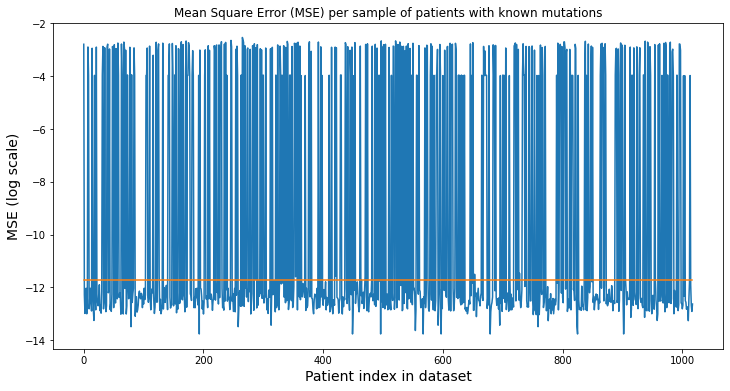

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Mean Square Error (MSE) per sample of patients with known mutations")
plt.xlabel("Patient index in dataset", size=14)
plt.ylabel("MSE (log scale)", size=14)
plt.plot(list(range(len(mse_all))), np.log(mse_all))
plt.plot(list(range(len(mse_all))), [np.log(threshold) for _ in list(range(len(mse_all)))])
plt.show()

In [ ]:
## save MSE results
mse_all_tosave = np.array(mse_all)
np.save(os.path.join(config["train_dir"], "mse_all_1000_samples.npy"), mse_all_tosave)

In [ ]:
min(mse_all), max(mse_all), threshold

(1.045346412143244e-06, 0.07966629029566005, 8.234402473534644e-06)

## Results and models comparison

In [ ]:
df_sick["anomaly_detected"] = mse_all > threshold

In [ ]:
df_sick.head()

,coding_sequence,mutation_kind,anomaly_detected
0,ATGCAGAGAAGTCCGTTAGAAAAGGCTAGCGTGGTCAGCAAGTTAT...,7,True
1,GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGC...,6,False
2,GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGC...,1,False
3,GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGC...,2,False
4,GTAGTAGGTCTTTGGCATTAGGAGCTTGAGCCCAGACGGCCCTAGC...,1,False


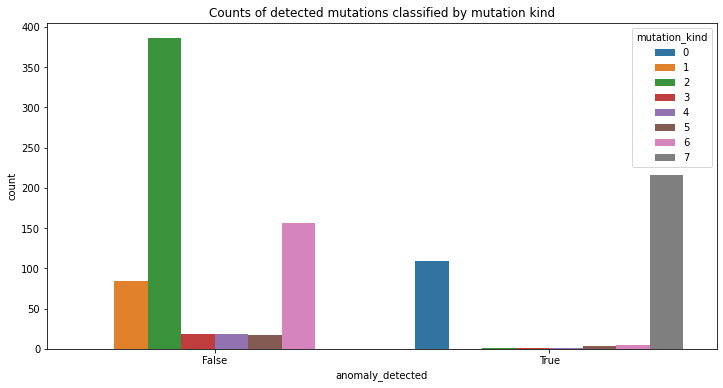

In [ ]:
plt.figure(figsize=(12, 6))
sbn.countplot(data=df_sick, x="anomaly_detected", hue="mutation_kind")
plt.title("Counts of detected mutations classified by mutation kind")
plt.show()

## Split dataset

In [ ]:
train_df, test_df = train_test_split(dataset_cp, test_size=.2, random_state=1999)

train_df.shape, test_df.shape

((1614, 4), (404, 4))

In [ ]:
mse_all = []
for gene in test_df['coding_sequence']:
    
    gene_split = gene_index(gene)
    t_mat = compute_transition_matrix(gene_split, ['T', 'A', 'C', 'G'])
    
    
    t_mat /= np.sum(t_mat, axis=1, keepdims=True)
    
    mse = np.sum((transition_matrix - t_mat) ** 2)
    mse_all.append(mse)

test_df["anomaly_detected"] = mse_all > threshold

## Discrete-Time discrete value Markov chain

Markov chain acc =  0.5420792079207921


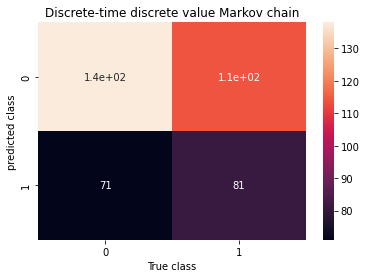

In [ ]:
print("Markov chain acc = ", accuracy_score(test_df.is_normal, test_df.anomaly_detected))
cmat_markov = confusion_matrix(test_df.is_normal, test_df.anomaly_detected)
sbn.heatmap(cmat_markov.T, annot=True)
plt.title("Discrete-time discrete value Markov chain")
plt.ylabel("predicted class")
plt.xlabel("True class")
plt.show()

# Models comparison with ML techniques

In [ ]:
X_train = train_df.coding_sequence.tolist()
y_train = train_df.is_normal.values

X_test = test_df.coding_sequence.tolist()
y_test = test_df.is_normal.values

In [ ]:

# vectorization
vect = CountVectorizer()
vect = vect.fit(X_train)
X_train = vect.transform(X_train).toarray()
X_test = vect.transform(X_test).toarray()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1614, 1466), (1614,), (404, 1466), (404,))

## Gaussian Naive bayes

Gaussian NB acc =  0.5222772277227723


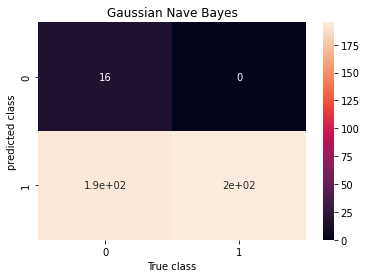

In [ ]:
### train
NB_model = GaussianNB()

NB_model.fit(X_train, y_train)

GNB_preds = NB_model.predict(X_test)

print("Gaussian NB acc = ", NB_model.score(X_test, y_test))

# confusion matrix
cmat_GNB = confusion_matrix(y_test, GNB_preds)
sbn.heatmap(cmat_GNB.T, annot=True)
plt.title("Gaussian Nave Bayes")
plt.ylabel("predicted class")
plt.xlabel("True class")
plt.show()

## Multinomial Naive bayes

Multinomial NB acc =  0.6361386138613861


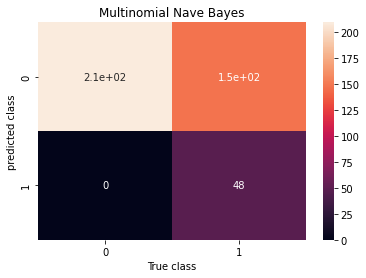

In [ ]:
m_NB = MultinomialNB()

m_NB.fit(X_train, y_train)

MNB_preds = m_NB.predict(X_test)

print("Multinomial NB acc = ", m_NB.score(X_test, y_test))

# confusion matrix
cmat_MNB = confusion_matrix(y_test, MNB_preds)
sbn.heatmap(cmat_MNB.T, annot=True)
plt.title("Multinomial Nave Bayes")
plt.ylabel("predicted class")
plt.xlabel("True class")
plt.show()

## RandomForest classifier

RF classifier acc =  0.6361386138613861


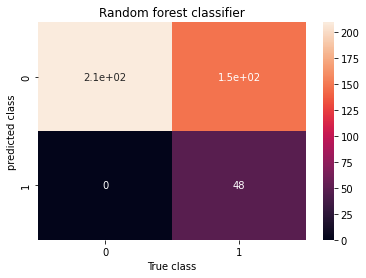

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

print("RF classifier acc = ", rf_model.score(X_test, y_test))

# confusion matrix
cmat_RF = confusion_matrix(y_test, rf_preds)
sbn.heatmap(cmat_RF.T, annot=True)
plt.title("Random forest classifier")
plt.ylabel("predicted class")
plt.xlabel("True class")
plt.show()